# Isotopic lapse rate estimated with Rayleigh distillation

**Short summary:** In this notebook, we will simulate how the isotopic composition ($\delta^{18}$O and $\delta$D) of precipitation changes as a function of altitude. We will use a simplified version of the Rayleigh distillation model for an open system, coupled with basic parameterizations of atmospheric column dynamics. The isotopic lapse rate, also known as the altitude effect, will be obtained by following the path of Rayleigh distillation in the $\delta$ vs. Altitude (m ASL) space.

# Introduction
The altitude effect (Dansgaard, 1964) is one of the most widely used properties of the stable isotopic composition of precipitation because it provides a direct link between the altitude at which the precipitation is collected and its isotopic composition. This is particularly useful for estimating the recharge area of groundwater or the catchment altitude of surface water bodies (e.g., lakes, streams).


![Fig.1](fig1.png "The altitude effect.")

# Support functions: atmospheric properties
To describe the changes in the isotopic composition of precipitation we need a set of functions that can describe the thermodynamic properties of the atmosphere. Such functions will include:
- Conversion utilities (altitude to pressure level)
- Calculation of air density
- Water vapor saturation pressure

In [1]:
"""
NAME: m2hPa(z)

DESCRIPTION: estimate atmospheric pressure at given altitude above mean sea level
             Air pressure at sea level is considered 1013.25 hPa
             www.weather.gov/epz/wxcalc_pressurealtitude

INPUT:
    z, meters above sea level (m)
    
OUTPUT:
    float, atmospheric pressure (hPa)
"""
def  m2hPa(m):
    return (1-(m/44307.69396))**(1/0.190284)*1013.25


"""
NAME: hPa2m(hPa)

DESCRIPTION: estimate altitude at given atmospheric pressure above mean sea level
             Air pressure at sea level is considered 1013.25 hPa
             www.weather.gov/epz/wxcalc_pressurealtitude

INPUT:
    hPa, atmospheric pressure (hPa)
    
OUTPUT:
    float, meters above sea level (m)
"""
def hPa2m(hPa):
    return (1-(hPa/1013.25)**0.190284)*44307.69396

"""
NAME: rhoAir(z, T)

DESCRIPTION: estimate air density at given altitude and temperature above 
             mean sea level. Air pressure at sea level is considered 1013.25 hPa

INPUT:
    z, meters above sea level (m)
    T, air temperature at altitude z (°C)
    
OUTPUT:
    float, air density (kg m^-3)
"""
def rhoAir(z, T):
    # Universal gas constant for dry air (J kg^-1 K^-1)
    # https://www.skybrary.aero/index.php/Density_Altitude
    Rair = 287.058
    # Convert °C to K
    T = T + 273.15
    # Estimate air pressure at given height
    airP = (1-(z/44307.69396))**(1/0.190284)*1013.25
    # Return air density 
    return 100*airP/(Rair*T)

"""
NAME: SatVapPress(T)

DESCRIPTION: estimate saturation water vapor pressure (Pa) at given temperature (°C)
using the Buck formula which has the lowest error in temperature range 0-35°C
References: Buck, A. L. (1981), "New equations for computing vapor pressure 
and enhancement factor", J. Appl. Meteorol., 20: 1527–1532

INPUT:
    T, temperature (°C)
    
OUTPUT:
    float, water vapor pressure (hPa)
"""

def SatVapPress(T):
    from math import exp # required exp
    return 6.1121*exp((18.678-T/234.5)*(T/(257.14+T)))

# Support functions: isotopic fractionation
We will also need a set of functions that will enable us to calculate the isotopic fractionation coefficients between different phases (e.g. vapor-liquid).

In [2]:
"""
NAMES: alpha18(T), alpha2(T)

DESCRIPTION: calculate equilibrium fractionation factor for Oxigen18/Oxygen16 and
Deuterium/Hydrogen ratios on liquid/vapor system at given temperature (°C) 
between -5°C and +100°C with the formula of Majoube (1971)
below -5°C with the formula of Ellehoj et al. (2013)
REFERENCES: 
    Majoube, Michel. "Fractionnement en oxygene 18 et en deuterium entre l’eau et sa vapeur." 
Journal de Chimie Physique 68 (1971): 1423-1436.
    Ellehoj, M. D., et al. "Ice‐vapor equilibrium fractionation factor of hydrogen and oxygen isotopes: 
Experimental investigations and implications for stable water isotope studies." 
Rapid Communications in Mass Spectrometry 27.19 (2013): 2149-2158.


INPUT:
    T, temperature (°C)
    
OUTPUT:
    float, liquid/vapor fractionation factor (-)

"""

def alpha18(T):
    from math import exp # required exp
    T = T+273.15 # Convert °C to K
    if T>=268.16:
        return exp((1137/(T**2))-(0.4156/T)-0.0020667)
    else:
        return exp((8312.58/(T**2))-(49.192/T)+0.0831)

def alpha2(T):
    from math import exp # required exp
    T = T+273.15 # Convert °C to K
    if T>=268.16:    
        return exp((24844/(T**2))-(76.248/T)+(0.052612))
    else:
        return exp((48888/(T**2))-(203.10/T)+0.2133)


# The Rayleigh distillation model for open system
During water vapor condensation, the heavier water vapor molecules in the air parcel will preferentially change from the water vapor state to the liquid phase. At the same time, the lighter water vapor moleculs will preferentially stay in the vapor phase. 

![Fig.2](fig2.png "The Rayleigh model")

The equation that describe such process, if the the *condensed* phase is removed at each distillation stage, is named *Rayleigh distillation for open systems* where:
- Rayleigh distillation describes the continuos change of composition in a binary mixture (also named Rayleigh Still, Lord Rayleigh, 1902),
- Open system refers to the fact that at each condensation stage, the condensed material is removed from the system (see e.g. Gat 1996 for other processes).

Following the above figure, we can define the ratio (*R*) between heavy and light molecules in a water vapor mass as:

$$R=\frac{N_i}{N_j}$$
$$N=N_{i} + N_{j}$$

where $N_i$ is the number of heavy water vapor molecules and $N_j$ is the number of the light ones. Given that $N_{j} >> N_{i}$ it is reasonable to approximate $N\approx N_j$. Hence, the ratio of the different isotopic species in water vapor become $R=N_{i}/N$. Changes in the isotopic composition of the mixture can therefore be expressed with the follwing separable ODE:

$$ \frac{dR}{dN} = \frac{1}{N}\left( \frac{dN_i}{dN} - \frac{N_i}{N}\right)$$
$$ \frac{dR}{dN} = \frac{R}{N}(\alpha -1)$$

where $\alpha$ is the isotopic fractionation factor at equilibrium (relative humidity is 100%).
The ODE can be integrated for $R_0$ and $N_0$ as follows:

$$\int_{R_0}^{R} \frac{dR}{R} = \int_{N_0}^{N} (\alpha - 1 )\frac{dN}{N}$$

$$\frac{R}{R_0} = \frac{N}{N_0}^{(\alpha - 1)}$$ 

Defining $f=N/N_0$ as the *fraction* of remaining water vapor in the air parcels, we can extrapolate its isotopic composition with

$$ R = R_0 f^{\alpha -1}$$

In [3]:
"""
NAME: rayleigh(R0, f, alpha)

DESCRIPTION: Rayleight distilaltion model for an open system.

INPUT:
    R0, initial isotopic ratio of water vapor (-)
    f, remaining water vapor fraction in the air parcel (-)
    alpha, the isotopic fractionation coefficient (-)
    
OUTPUT:
    float, isotopic ratio at given distillation (f) stage (-)

"""

def rayleigh(R0, f, alpha):
    return R0*f**(alpha - 1)

# Setup the model
We need to import the right python modules and setup some general settings in order to run the code. See [here](https://www.spc.noaa.gov/exper/mesoanalysis/help/help_lllr.html#:~:text=Values%20less%20than%205.5%2D6.0,that%20if%20enough%20moisture%20is) for realistic values of the atmospheric lapse rate. In this case we can use 6, which is very similar to the ~6.1 identified across North-Eastern Italy (Masiol et al., 2021).

In [4]:
import numpy as np
from scipy.stats import linregress
from matplotlib import pyplot as plt
plt.style.use('bmh')


#%% Settings
# Simulation parameters and boundary conditions
MLR         = 6                 # °C/km, Moist adiabatic lapse rate 
MinZ        = 0                 # m, lowest altitude of the simulation
MaxZ        = 3000              # m, top level of the simulation
Zres        = 1                 # m, vertical resolution of the simulation

We also need to specify the initial conditions of the model. Givent that isotopic ratios are usually reported in delta-unit ($\delta$, ‰), we will use the delta notation hereafter:

$$\delta = \frac{R}{R_{std}} - 1 $$

where *R* is the isotopic ratio in the water of interest (e.g. precipitation) and in the standard. In isotope hydrology, the standard used for normalization is the Vienna Standard Mean Ocean Water (VSMOW), which is by defition $\delta^{18}O = 0$‰ and $\delta D = 0$‰.

In [5]:
# Initial conditions of the simulation
Tz0         = 20                # °C, air temperature at z=MinZ m ASL
P0          = 1013.25           # hPa, atmospheric pressure at z=0 
RH0         = 80/100            # %, Water vapor concentration
d18O0       = -12               # ‰, Water vapor initial d18O 
dD0         = d18O0*8+10        # ‰, Water vapor initial dD, typical GMWL value

We can also define the functions to convert back and forth between R and $\delta$ using the absolue isotopic ratio of VSMOW as follows:

In [6]:
VSMOW21     = 155.76*1e-6 
VSMOW1816     = 2005.20*1e-6

"""
NAME: R_DH_2dD(R)

DESCRIPTION: convert the isotopic ratio (R) D/H to delta unit (dD)

INPUT:
    R, isotopic ratio (-)
    
OUTPUT:
    float, isotopic ratio in delta notation (‰)

"""

def R_DH_2dD(R):
    return ((R/VSMOW21)-1)*1000

"""
NAME: R_1816_2d18O(R)

DESCRIPTION: convert the isotopic ratio (R) 18-O/16-O to delta unit (d18O)

INPUT:
    R, isotopic ratio (-)
    
OUTPUT:
    float, isotopic ratio in delta notation (‰)

"""

def R_1816_2d18O(R):  
    return ((R/VSMOW1816)-1)*1000

"""
NAME: dD_2R_DH(dD)

DESCRIPTION: convert delta unit (dD) to D/H isotopic ratio (R)

INPUT:
    dD, isotopic ratio in delta notation (‰)
    
OUTPUT:
    float, isotopic ratio (-)

"""

def dD_2R_DH(dD):
    return ((dD/1000)+1)*VSMOW21

"""
NAME: d18O_2R_1816(d18O)

DESCRIPTION: convert delta unit (d18O) to 18-O/16-O isotopic ratio (R)

INPUT:
    d18O, isotopic ratio in delta notation (‰)
    
OUTPUT:
    float, isotopic ratio (-)

"""

def d18O_2R_1816(d18O):
    return ((d18O/1000)+1)*VSMOW1816

# Simulate the vertical profile of the atmosphere
We can now simulate the vertical profiles of temperature and humidity in the atmosphere.

Text(0.5, 0, 'f')

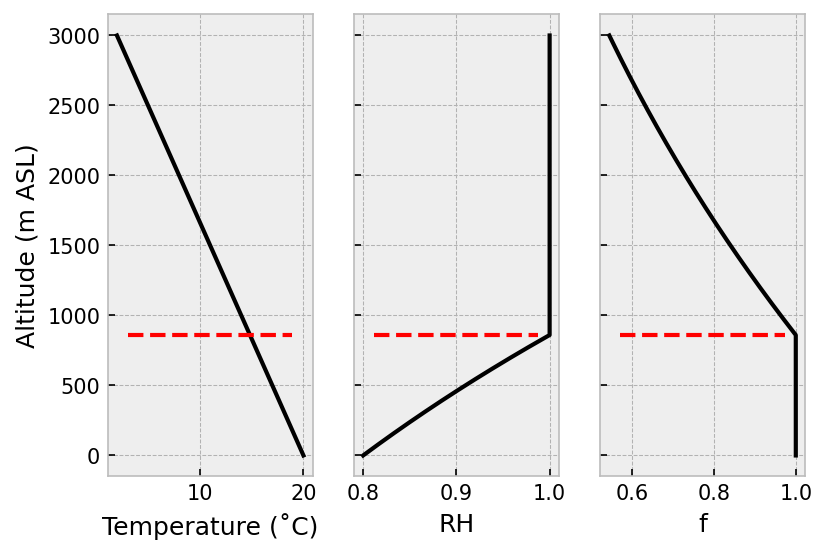

In [7]:
Zvector                 = np.linspace(MinZ, MaxZ, int((MaxZ - MinZ)/Zres))    # Altitude levels 
Pvector                 = np.zeros(shape=(len(Zvector),1))                    # Pressure levels
Tvector                 = Tz0 - (Zvector*MLR/1000)                            # Air temperature 
VaporConcentration      = np.zeros(shape=(len(Zvector),1))                    # Water vapor concentration 
RHvector                = np.zeros(shape=(len(Zvector),1))                    # Relative Humidity
VaporFraction           = np.ones(shape=(len(Zvector),1))                     # Residual fraction of water vapor

# Calculate pressure vector
for idx in range(len(Zvector)):
    Pvector[idx] = m2hPa(Zvector[idx])
#    VaporConcentration[idx] = SatVapPress(Tvector[idx])

# Zero level properties
RHvector[0]             = RH0
VaporConcentration[0]   = 1e6*(RH0)*SatVapPress(Tz0)/P0


# Threshold level for condensation
RH_thres = 1



for idx in range(1, len(Zvector)):
    RHvector[idx] = (((VaporConcentration[idx-1]/1e6)*Pvector[idx]))/(SatVapPress(Tvector[idx]))
    if RHvector[idx]>RH_thres: # Condensation occurs
        RHvector[idx] = 1
         # New mixing ratio
        VaporConcentration[idx] = 1e6*SatVapPress(Tvector[idx])/m2hPa(idx)
        # Estimate fraction of residual water vapor
        VaporFraction[idx] = VaporConcentration[idx]/VaporConcentration[0]
    else:
        VaporConcentration[idx] = VaporConcentration[idx-1]
        VaporFraction[idx] = VaporFraction[idx-1]

# Adjust f for numerical errors
#VaporFraction[VaporFraction>1] = 1
            

fig, ax = plt.subplots(ncols = 3, sharey = True, figsize = (6, 4), dpi = 150)
ax[0].plot(Tvector, Zvector, 'k-')
ax[1].plot(RHvector, Zvector, 'k-')
ax[2].plot(VaporFraction, Zvector, 'k-')

# Plot at which altitude the water vapor starts to condensate
idxOI = np.where(RHvector >= RH_thres)[0][0]
for axis in ax:
    axis.axhline(y=Zvector[idxOI], xmin=0.1, xmax=.9, color = 'r', ls = '--')

# Add labels
ax[0].set_ylabel('Altitude (m ASL)')
ax[0].set_xlabel('Temperature (˚C)')
ax[1].set_xlabel('RH')
ax[2].set_xlabel('f')

In the figure above, the red-dashed line represents the altitude at which the water vapor starts to condensate, i.e. where the Rayleigh distillation starts to work. Below that level, the isotopic composition of the water vapor is unchanged$^{[1]}$. Hence, we can start calculating the isotopic composition of the remaining water vapor in air parcel during the lift and with mass closure we can calculate the isotopic composition of precipitation:

$$ \delta_{precip} = \frac{f_{l0} \delta_{vapor-l0} - f_{l1} \delta_{vapor-l1}}{f_{l0}-f_{l1}} $$

where:
- $ \delta_{precip}$ is the isotopic composition of precipitation for that altitude level
- $ \delta_{vapor}$ is the isotopic composition of water vapor at current level (l1) and one step before (l0)
- $f$ is the water vapor fraction at current level (l1) and one step before (l0)

$^{[1]}$ In the real world, water vapor get depleted with altitude because of mixing with the higher troposphere.

In [8]:
VaporComposition        = np.zeros(shape=(len(Zvector), 2))             # Water vapor composition. Column 1 d18O, Column 2 dD
VaporComposition[0,0]   = d18O0
VaporComposition[0,1]   = dD0
PrecComposition         = np.zeros(shape=(len(Zvector), 2))             # Precipitation composition. Column 1 d18O, Column 2 dD

for idx in range(1, len(Zvector)):
    #RHvector[idx] = (((VaporConcentration[idx-1]/1e6)*P0))/(SatVapPress(Tvector[idx]))
    if RHvector[idx] == RH_thres: # Condensation occurs
        # Estimate isotopic composition of water vapor
        R1816_VAP = rayleigh(R0=d18O_2R_1816(d18O0), 
                             f=VaporFraction[idx], 
                             alpha=alpha18(Tvector[idx]))
        RDH_VAP = rayleigh(R0=dD_2R_DH(dD0), 
                           f=VaporFraction[idx], 
                           alpha=alpha2(Tvector[idx]))
        
        # Convert to delta units
        VaporComposition[idx, 0] = R_1816_2d18O(R1816_VAP)
        VaporComposition[idx, 1] = R_DH_2dD(RDH_VAP)
        
        # Estimate isotopic composition of precipitation by mass balance
        if (VaporFraction[idx-1]-VaporFraction[idx]) > 0:
            PrecComposition[idx,0] = (VaporFraction[idx-1]*VaporComposition[idx-1, 0] - VaporFraction[idx]*VaporComposition[idx, 0])/(VaporFraction[idx-1]-VaporFraction[idx])
            PrecComposition[idx,1] = (VaporFraction[idx-1]*VaporComposition[idx-1, 1] - VaporFraction[idx]*VaporComposition[idx, 1])/(VaporFraction[idx-1]-VaporFraction[idx])    
    else: 
        VaporComposition[idx, 0] = d18O0
        VaporComposition[idx, 1] = dD0

# Fill positions before condensation occurred,
PrecComposition[:idxOI+1, 0] = np.nan
PrecComposition[:idxOI+1, 1] = np.nan

Now we can plot the vertical profile of the isotopic composition of water vapor and precipitation ($\delta^{18}$O).

Text(0.5, 0, '$\\delta^{18}$O Precip (‰)')

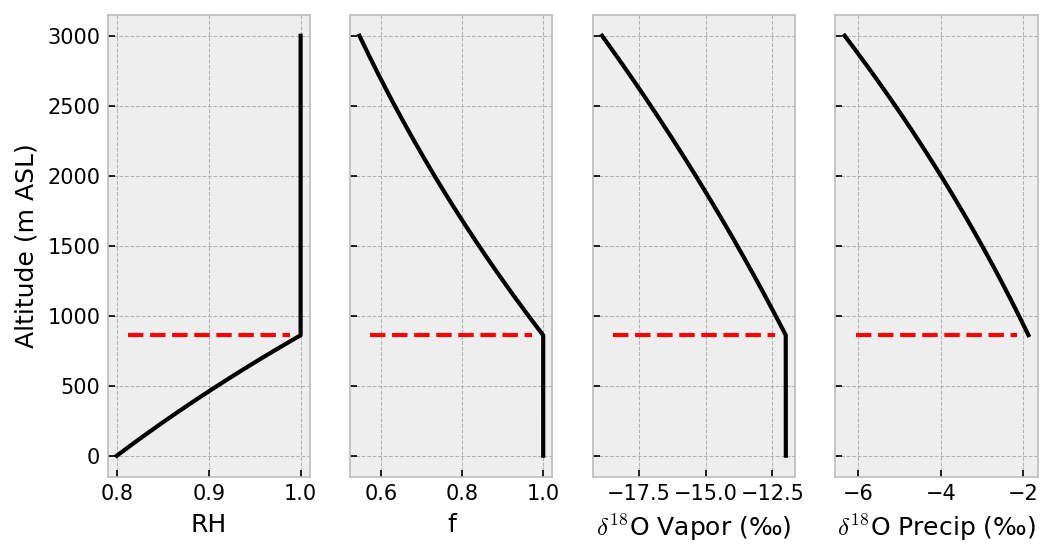

In [9]:
fig, ax = plt.subplots(ncols = 4, sharey = True, figsize = (8, 4), dpi = 150)
ax[0].plot(RHvector, Zvector, 'k-')
ax[1].plot(VaporFraction, Zvector, 'k-')
ax[2].plot(VaporComposition[:,0], Zvector, 'k-')
ax[3].plot(PrecComposition[:,0], Zvector, 'k-')
                            
# Plot at which altitude the water vapor starts to condensate
idxOI = np.where(RHvector >= RH_thres)[0][0]
for axis in ax:
    axis.axhline(y=Zvector[idxOI], xmin=0.1, xmax=.9, color = 'r', ls = '--')

# Add labels
ax[0].set_ylabel('Altitude (m ASL)')
ax[0].set_xlabel('RH')
ax[1].set_xlabel('f')
ax[2].set_xlabel('$\delta^{18}$O Vapor (‰)')
ax[3].set_xlabel('$\delta^{18}$O Precip (‰)')

Assuming that we can sample the precipitation at different altitudes, we can  simulate how the isotopic lapse rate looks like.

For instance, let's sample the precipitation ramdomly at 15 different altitudes between 2000 and 5000 m ASL.

Text(0, 0.5, '$\\delta^{18}$O$_{precip.}$ (‰)')

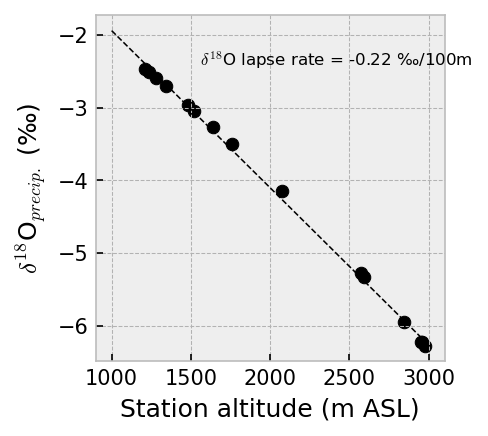

In [10]:
min_alt     = 1000 # minimum altitude for sampling precipitation
max_alt     = 3000 # maximum altitude for sampling precipitation
n_stations  = 15   # number of sampling stations

# Set the seed for reproducibility
seed = 1234 
rng = np.random.default_rng(seed)

# Generate sampling station altitudes
random_stations = rng.integers(min_alt, max_alt, n_stations)

# Preallocate memory for x,y vectors
x = np.array([])
y = np.array([])

for altitude in random_stations:
    idx_oi = np.where(np.round(Zvector)==altitude)[0][0]
    x = np.append(x, Zvector[idx_oi])
    y = np.append(y, PrecComposition[idx_oi, 0])
    
mdl = linregress(x,y)
dummyx = np.linspace(min_alt, max_alt, 10)
dummyy = dummyx*mdl.slope+mdl.intercept

fig, ax = plt.subplots(figsize = (3, 3), dpi = 150)
ax.scatter(x,y, label = 'Sampling stations', color = 'k')
ax.plot(dummyx, dummyy, 'k--', lw = .75)

# Show isotopic lapse rate
str_buff = "$\delta^{18}$O lapse rate = %.2f ‰/100m" % (mdl.slope*100)
ax.text(0.3, 0.9, str_buff, transform=ax.transAxes, fontsize=8, verticalalignment='top')

# Add labels
ax.set_xlabel('Station altitude (m ASL)')
ax.set_ylabel('$\delta^{18}$O$_{precip.}$ (‰)')

# References

Dansgaard, W. (1964). Stable isotopes in precipitation. tellus, 16(4), 436-468.

Gat, J. R. (1996). Oxygen and hydrogen isotopes in the hydrologic cycle. Annual Review of Earth and Planetary Sciences, 24(1), 225-262.

Masiol, M., Zannoni, D., Stenni, B., Dreossi, G., Zini, L., Calligaris, C., ... & Treu, F. (2021). Spatial distribution and interannual trends of δ18O, δ2H, and deuterium excess in precipitation across North-Eastern Italy. Journal of Hydrology, 598, 125749.

Rayleigh. (1902). On the distillation of binary mixtures. The London, Edinburgh and Dublin Philosophical Magazine and Journal of Science, series 6, 4, 521-537.